### **Credit Card Approval Prediction Using Machine Learning**

In [75]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [76]:
# Import datasets
application = pd.read_csv('Resources/application_record.csv', encoding = 'utf-8') 
record = pd.read_csv('Resources/credit_record.csv', encoding = 'utf-8')  

In [77]:
# Review the dataframes
application.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1


In [78]:
# Review the dataframes
record.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


### **Feature Engineering**

#### 1. Credit Card Account Payment Status

In [79]:
# Find users' accounts month records.
begin_month = pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month = begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 

# Merge with application dataframe
new_data = pd.merge(application,begin_month,how="left",on="ID")
new_data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,-26.0


In [80]:
# Choose users who overdue after 90 dyas
# These samples are marked as '0' or 'no'
record['dep_value'] = None
# These samples are marked as '1' or 'yes'
record['dep_value'][record['STATUS'] =='3'] = 'Yes' 
record['dep_value'][record['STATUS'] =='4'] = 'Yes' 
record['dep_value'][record['STATUS'] =='5'] = 'Yes' 

C:\Users\jhyan\AppData\Local\Temp\ipykernel_6684\1099934247.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record['dep_value'][record['STATUS'] =='3'] = 'Yes'
C:\Users\jhyan\AppData\Local\Temp\ipykernel_6684\1099934247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record['dep_value'][record['STATUS'] =='4'] = 'Yes'
C:\Users\jhyan\AppData\Local\Temp\ipykernel_6684\1099934247.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [81]:
# Clean up and summarize the dataframe
countuser = record.groupby('ID').count()

# Assign 'Yes' or 'No' to 'dep_value'"
countuser['dep_value'][countuser['dep_value'] > 0] = 'Yes' 
countuser['dep_value'][countuser['dep_value'] == 0] = 'No' 
countuser_new = countuser[['dep_value']]
countuser_new.head(5)

,dep_value
ID,
5001711,No
5001712,No
5001713,No
5001714,No
5001715,No


In [82]:
# Clean up and summarize the dataframe
new_data = pd.merge(new_data, countuser_new, how='inner', on='ID')

# Create a new column 'target' 
new_data['target'] = new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target'] = 1
new_data.loc[new_data['target']=='No','target'] = 0
new_data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month,dep_value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2,-15.0,No,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2,-14.0,No,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1,-26.0,No,0


In [83]:
# Show how many times each unique value appears
print(new_data['dep_value'].value_counts())
print(new_data['dep_value'].value_counts(normalize=True))

No     36155
Yes      302
Name: dep_value, dtype: int64
No     0.991716
Yes    0.008284
Name: dep_value, dtype: float64


#### Conclusion:

About 0.82% of users have overdue payments that are 90 days or more late, while approximately 99.2% of users make payments within 90 days.

### **Algorithms**

In [84]:
# Rename columns
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [85]:
# Drop rows with missing (NaN) values
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()
new_data.head(3)

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,...,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1,-26.0,No,0


In [86]:
# Show columns name
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'ChldNo', 'inc', 'inctp', 'edutp',
       'famtp', 'houtp', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'wkphone', 'phone', 'email', 'occyp', 'famsize', 'begin_month',
       'dep_value', 'target'],
      dtype='object')

In [87]:
# Prepare X and Y
Y = new_data['target']
X = new_data[['ChldNo', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'wkphone', 'phone', 'email', 'famsize']]

In [88]:
# Change the data type
Y = Y.astype(int)

from imblearn.over_sampling import SMOTE

# Create an instance of the SMOTE object
smote = SMOTE()

# Use SMOTE (Synthetic Minority Over-sampling Technique)
X_balance,Y_balance = smote.fit_resample(X, Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

In [89]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3, random_state = 10086)

### **Logistic Regression**

In [90]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy Score is 0.61488
      0     1
0  4412  3068
1  2693  4786
[[0.58983957 0.41016043]
 [0.36007488 0.63992512]]


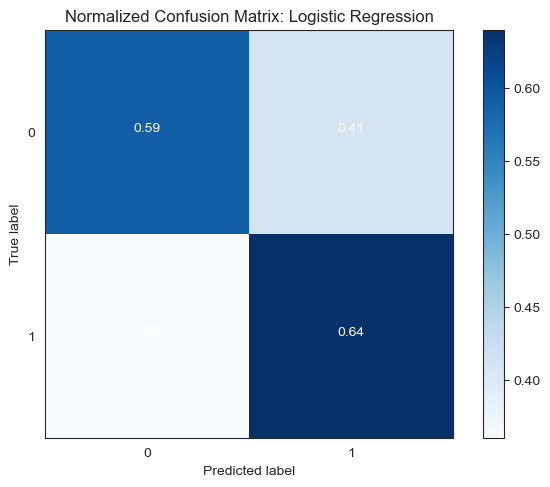

In [91]:
# Use Logistic Regression model
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

# Print out accuracy
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
# Print out confusion matrix
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

# Plot confusion matrix
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')
